In [1]:
import numpy as np
import pandas as pd
loans = pd.read_csv('lending-club-data-2.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
print(loans.shape)
loans.head(1)

(122607, 68)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1


In [3]:
loans.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'is_inc_v', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans',
       'bad_loans', 'emp_length_num', 'grade_num', '

In [4]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : 1 if x==0 else -1)

In [5]:
loans = loans.drop(['bad_loans'], axis = 1)

In [6]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'
loans = loans[features + [target]]

### Subsample dataset to make sure classes are balanced

In [7]:
## wait for later

loans.isnull().any().any()

loans.dropna(inplace=True)

False

In [8]:
loans.shape

(122607, 5)

In [10]:
loans.shape

(122607, 5)

## Split data into training and validation sets

In [11]:
import json

with open('train-idx-2.json', 'r') as f:
    train_idx = json.load(f)
    
with open('test-idx-2.json', 'r') as f:
    validation_idx = json.load(f)

## One-hot encoding

### Transform categorical data into binary features

In [12]:
def encoding_binary_feature(data, y_label):
    labels =  data.select_dtypes(include=[object])
    encoded_features =[]
    #encoded_values = np.transpose(np.array(np.ones(len(data),)))
    encoded_values = pd.DataFrame(data[y_label])   
    
    for label in labels:
        
        distinct_features = list(set(data[label].values))
    
        for feature in distinct_features:
            encoded_features.append(str(label + '.'+feature))
            
            #new_array = np.array(np.ones(len(data),))
            encoded_values[encoded_features[-1]] = data[label].apply(lambda x : +1 if x==feature else 0)
            
    # labels don't need encoding. we just add those 
    labels = data.select_dtypes(exclude=[object])
    for label in labels: 
        encoded_features.append(str(label))
        encoded_values[encoded_features[-1]] = data[label]
    
    return encoded_values

In [13]:
loans_data = encoding_binary_feature(loans,'safe_loans')
print(loans_data.columns.values)

['safe_loans' 'grade.F' 'grade.G' 'grade.B' 'grade.D' 'grade.C' 'grade.E'
 'grade.A' 'term. 36 months' 'term. 60 months' 'home_ownership.OTHER'
 'home_ownership.RENT' 'home_ownership.MORTGAGE' 'home_ownership.OWN'
 'emp_length.9 years' 'emp_length.6 years' 'emp_length.10+ years'
 'emp_length.2 years' 'emp_length.4 years' 'emp_length.7 years'
 'emp_length.< 1 year' 'emp_length.8 years' 'emp_length.5 years'
 'emp_length.3 years' 'emp_length.1 year' 'emp_length.n/a']


## Train_test split

In [14]:
train_data = loans_data.iloc[train_idx].drop(['safe_loans'], axis = 1)
train_Y = loans_data['safe_loans'].iloc[train_idx]
test_data = loans_data.iloc[validation_idx].drop(['safe_loans'], axis = 1)
test_Y = loans_data['safe_loans'].iloc[validation_idx]

# Weighted decision trees

Let's modify our decision tree code from Module 5 to support weighting of individual data points.

### Weighted error definition

Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $\alpha_1 ... \alpha_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


### Write a function to compute weight of mistakes

Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $\alpha_1 ... \alpha_n$

We are interested in computing the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

The function **intermediate_node_weighted_mistakes** should first compute two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **intermediate_node_weighted_mistakes** should return the lower of the two weights of mistakes, along with the class associated with that weight.

In [33]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights, key_value):
    # Sum the weights of all entries with label +1
    total_weight_positive = (data_weights[labels_in_node != +1]).sum()
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    weighted_mistakes_all_negative = data_weights[labels_in_node != -1]
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = weighted_mistakes_all_negative.sum()
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    #total_weight_positive = (data_weights[labels_in_node != +1]).sum()
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if (key_value == 1):
        return ((data_weights[labels_in_node == -1]).sum(), 1)
    
    elif (key_value == -1):
        return ((data_weights[labels_in_node == +1]).sum(), -1)
    else:
        
        if(total_weight_negative >= total_weight_positive):
            return (total_weight_positive, 1)
        else:
            return (total_weight_negative, -1)

**Checkpoint:** Test your **intermediate_node_weighted_mistakes** function

In [34]:
example_labels = np.array([-1, -1, 1, 1, 1])
example_data_weights = np.array([1., 2., .5, 1., 1.])


if intermediate_node_weighted_mistakes(example_labels, example_data_weights, 0) == (2.5, -1):
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


**classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

**Quiz Question:** If we set the weights $\mathbf{\alpha} = 1$ for all data points, how is the weight of mistakes $\mbox{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ related to the `classification error`?

### Function to pick best feature to split on

We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The **best_splitting_feature** function is similar to the one from the earlier assignment with two minor modifications:
  1. The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.

In [149]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] ==1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(target[data[feature] == 0], left_data_weights, 0)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(target[data[feature] == 1], right_data_weights, 0)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes + right_weighted_mistakes)/data_weights.sum()
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [150]:
features = train_data.columns.values

In [151]:
features

array(['grade.F', 'grade.G', 'grade.B', 'grade.D', 'grade.C', 'grade.E',
       'grade.A', 'term. 36 months', 'term. 60 months',
       'home_ownership.OTHER', 'home_ownership.RENT',
       'home_ownership.MORTGAGE', 'home_ownership.OWN',
       'emp_length.9 years', 'emp_length.6 years', 'emp_length.10+ years',
       'emp_length.2 years', 'emp_length.4 years', 'emp_length.7 years',
       'emp_length.< 1 year', 'emp_length.8 years', 'emp_length.5 years',
       'emp_length.3 years', 'emp_length.1 year', 'emp_length.n/a'], dtype=object)

In [152]:
example_data_weights = np.array(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, train_Y, example_data_weights) == 'term. 36 months':
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }
    
Let us start with a function that creates a leaf node given a set of target values:

In [27]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True,
           #'left': None,
          # 'right': None,
           #'features_remaining': None
           }
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights, 0)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf 

We provide a function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [153]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = target
    print ("--------------------------------------------------------------------")
    print ("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights, 0)[0] <= 1e-15:
        print ("Stopping condition 1 reached." )
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print ("Stopping condition 2 reached.")                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print ("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    
    
    #remaining_features.remove(splitting_feature)
    remaining_features = [x for x in remaining_features if x != splitting_feature]
    
    
    left_target = target_values[data[splitting_feature] == 0]    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    left_split = data[data[splitting_feature] == 0]
    
    
    right_target = target_values[data[splitting_feature] == 1]   
    right_split = data[data[splitting_feature] == 1]   
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print ("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf( target_values[data[splitting_feature] == 0], left_data_weights)
    if len(right_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(target_values[data[splitting_feature] == 1], right_data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, left_target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, right_target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Here is a recursive function to count the nodes in your tree:

In [29]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [154]:
example_data_weights = np.array([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, train_Y,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print ('Test passed!')
else:
    print ('Test failed... try again!')
    print ('Number of nodes found:', count_nodes(small_data_decision_tree))
    print ('Number of nodes that should be there: 7' )

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  del sys.path[0]


Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade.D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data points).
Reached maximum depth. Stopping for now.
Test passed!


Let us take a quick look at what the trained tree is like. You should get something that looks like the following

```
{'is_leaf': False,
    'left': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'splitting_feature': 'grade.A'
     },
    'prediction': None,
    'right': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'splitting_feature': 'grade.D'
     },
     'splitting_feature': 'term. 36 months'
}```

In [155]:
import pprint
pprint.pprint(small_data_decision_tree)

{'is_leaf': False,
 'left': {'is_leaf': False,
          'left': {'is_leaf': True,
                   'prediction': -1,
                   'splitting_feature': None},
          'prediction': None,
          'right': {'is_leaf': True,
                    'prediction': 1,
                    'splitting_feature': None},
          'splitting_feature': 'grade.A'},
 'prediction': None,
 'right': {'is_leaf': False,
           'left': {'is_leaf': True,
                    'prediction': 1,
                    'splitting_feature': None},
           'prediction': None,
           'right': {'is_leaf': True,
                     'prediction': -1,
                     'splitting_feature': None},
           'splitting_feature': 'grade.D'},
 'splitting_feature': 'term. 36 months'}


### Making predictions with a weighted decision tree

In [40]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print ("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print ("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

Now, we will write a function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function called **evaluate_classification_error** takes in as input:
1. `tree` (as described above)
2. `data` (an SFrame)

The function does not change because of adding data point weights.

In [156]:
def evaluate_classification_error(tree, data, target):
    # Apply the classify(tree, x) to each row in your data
    #prediction = data.apply(lambda x: classify(tree, x))
    prediction =[]
    for i in range(len(data)):
        prediction.append(classify(tree, data.iloc[i]))
    
    # Once you've made the predictions, calculate the classification error and return it
    errors = (prediction == target).sum()/len(target)
    return errors

In [157]:
evaluate_classification_error(small_data_decision_tree, test_data, test_Y)

0.6018957345971564

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Let us fit a weighted decision tree with `max_depth = 2`.

In [158]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, train_Y,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  del sys.path[0]


Split on feature home_ownership.RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade.F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade.D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stopping condition 1 reached.


Now, we will compute the classification error on the `subset_20`, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [159]:
subset_20_X = train_data[0:10].append(train_data[-10:])
subset_20_Y = train_Y[0:10].append(train_Y[-10:])

evaluate_classification_error(small_data_decision_tree_subset_20, subset_20_X, subset_20_Y)

0.94999999999999996

Now, let us compare the classification error of the model `small_data_decision_tree_subset_20` on the entire test set `train_data`:

In [160]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data, train_Y)

0.51875134321942828

The model `small_data_decision_tree_subset_20` performs **a lot** better on `subset_20` than on `train_data`.

So, what does this mean?
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are basically ignored during training.

**Quiz Question**: Will you get the same model as `small_data_decision_tree_subset_20` if you trained a decision tree with only the 20 data points with non-zero weights from the set of points in `subset_20`?

# Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **`max_depth=1`**.

Recall from the lecture the procedure for Adaboost:

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$
  
Complete the skeleton for the following code to implement **adaboost_with_tree_stumps**. Fill in the places with `YOUR CODE HERE`.

In [166]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = target
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration %d' % t)
        print ('====================================================='        )
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target_values, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        #predictions = data.apply(lambda x: classify(tree_stump, x))
        predictions =[]
        for i in range(len(data)):
            predictions.append(classify(tree_stump, data.iloc[i]))
            
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = (predictions == target_values)
        is_wrong   = (predictions != target_values)
        
        # Compute weighted error
        weighted_error = (is_wrong).sum()/len(predictions)
        
        # Compute model coefficient using weighted error
        weight = float(1/2 * log((1 - weighted_error)/weighted_error))
        #if(len(weights) ==0 ):
        #weights.append(weight, axis =1)
        weights.append(weight)
        print('weight: ', weight )
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        alpha = alpha * adjustment       
        alpha = alpha/alpha.sum()
        #for i in range(len(weights)):
         #   weights[i] = weights[i]/sum(weights)
      
        
    return weights, tree_stumps

### Checking your Adaboost code

Train an ensemble of **two** tree stumps and see which features those stumps split on. We will run the algorithm with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 2`

In [167]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, train_Y, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  del sys.path[0]


Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
weight:  0.15802933659263743
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
weight:  0.13393507398795024


In [168]:
len(tree_stumps)

2

In [122]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print ("(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('.')
    print ('                       root')
    print ('         |---------------|----------------|')
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name))))
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

Here is what the first stump looks like:

In [169]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term. 36 months == 0]            [term. 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [170]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.A == 0]                    [grade.A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [171]:
print(stump_weights)

[0.15802933659263743, 0.13393507398795024]


If your Adaboost is correctly implemented, the following things should be true:

* `tree_stumps[0]` should split on **term. 36 months** with the prediction -1 on the left and +1 on the right.
* `tree_stumps[1]` should split on **grade.A** with the prediction -1 on the left and +1 on the right.
* Weights should be approximately `[0.158, 0.177]` 

**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{\alpha}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{\alpha}$) tell you how important each data point is while training a decision stump.

### Training a boosted ensemble of 10 stumps

Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [173]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                train_Y, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  del sys.path[0]


Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
weight:  0.15802933659263743
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
weight:  0.13393507398795024
Adaboost Iteration 2
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data point

## Making predictions

Recall from the lecture that in order to make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

Complete the following skeleton for making predictions:

In [195]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        
        predictions =[]
        for j in range(len(data)):
            predictions.append(classify(tree_stump, data.iloc[j]) * stump_weights[i])
        #predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        scores = scores + predictions
    
    for i in range(len(scores)):
        scores[i] = 1 if scores[i]>0 else -1
    return scores

In [191]:
def decision_stump_accuracy(test_Y, predictions):
    return (test_Y == predictions).sum()/len(test_Y)

In [196]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = decision_stump_accuracy(test_Y, predictions)
print ('Accuracy of 10-component ensemble = %s' % accuracy )

Accuracy of 10-component ensemble = 0.610404997846


Now, let us take a quick look what the `stump_weights` look like at the end of each iteration of the 10-stump ensemble:

In [197]:
stump_weights

[0.15802933659263743,
 0.13393507398795024,
 0.08233686076291172,
 0.08314832274629912,
 0.06542739271146769,
 0.13393507398795024,
 0.0248815571981286,
 0.07228337594908205,
 0.04968623690660178,
 -0.0823368607629119]

# Performance plots

In this section, we will try to reproduce some of the performance plots dicussed in the lecture.

### How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Once we are done with this, we will then do the following:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

First, lets train the model.

In [199]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, train_Y, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  del sys.path[0]


Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
weight:  0.15802933659263743
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
weight:  0.13393507398795024
Adaboost Iteration 2
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data point

weight:  -0.0823368607629119
Adaboost Iteration 14
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.D. (30465, 6759)
--------------------------------------------------------------------
Subtree, depth = 2 (30465 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6759 data points).
Reached maximum depth. Stopping for now.
weight:  -0.0823368607629119
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.D. (30465, 6759)
--------------------------------------------------------------------
Subtree, depth = 2 (30465 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6759 data points).
Reached maximum depth. Stopping for now.
we

weight:  -0.0823368607629119
Adaboost Iteration 28
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.D. (30465, 6759)
--------------------------------------------------------------------
Subtree, depth = 2 (30465 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6759 data points).
Reached maximum depth. Stopping for now.
weight:  -0.0823368607629119
Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.D. (30465, 6759)
--------------------------------------------------------------------
Subtree, depth = 2 (30465 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6759 data points).
Reached maximum depth. Stopping for now.
we

### Computing training error at the end of each iteration

Now, we will compute the classification error on the **train_data** and see how it is reduced as trees are added.

In [201]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - decision_stump_accuracy(train_Y, predictions)
    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.421636578551
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.400655491081
Iteration 5, training error = 0.384724908661
Iteration 6, training error = 0.405249301526
Iteration 7, training error = 0.383462282398
Iteration 8, training error = 0.382763808296
Iteration 9, training error = 0.382736943907
Iteration 10, training error = 0.392112615517
Iteration 11, training error = 0.394557274876
Iteration 12, training error = 0.409171502257
Iteration 13, training error = 0.417015903718
Iteration 14, training error = 0.435498603052
Iteration 15, training error = 0.458199011391
Iteration 16, training error = 0.458924349882
Iteration 17, training error = 0.458924349882
Iteration 18, training error = 0.458924349882
Iteration 19, training error = 0.458924349882
Iteration 20, training error = 0.458924349882
Iteration 21, training error = 0.458924349882
Iteration 22, training error = 0.4589243498

### Visualizing training error vs number of iterations

We have provided you with a simple code snippet that plots classification error with the number of iterations. 

In [202]:
import matplotlib.pyplot as plt
%matplotlib inline

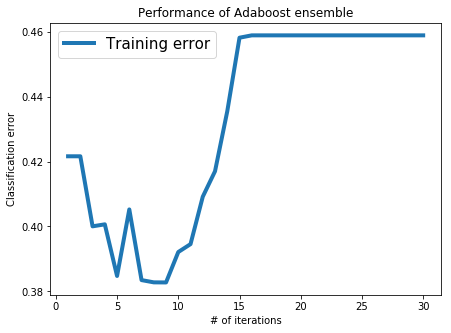

In [203]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [204]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - decision_stump_accuracy(test_Y, predictions)
    test_error_all.append(error)
    print ("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.42330891857
Iteration 2, test error = 0.42330891857
Iteration 3, test error = 0.398104265403
Iteration 4, test error = 0.398750538561
Iteration 5, test error = 0.379900904782
Iteration 6, test error = 0.399827660491
Iteration 7, test error = 0.380331753555
Iteration 8, test error = 0.379254631624
Iteration 9, test error = 0.379254631624
Iteration 10, test error = 0.389595002154
Iteration 11, test error = 0.392072382594
Iteration 12, test error = 0.40725980181
Iteration 13, test error = 0.415445928479
Iteration 14, test error = 0.438173201206
Iteration 15, test error = 0.460254200776
Iteration 16, test error = 0.460577337355
Iteration 17, test error = 0.460577337355
Iteration 18, test error = 0.460577337355
Iteration 19, test error = 0.460577337355
Iteration 20, test error = 0.460577337355
Iteration 21, test error = 0.460577337355
Iteration 22, test error = 0.460577337355
Iteration 23, test error = 0.460577337355
Iteration 24, test error = 0.460577337355
Iter

### Visualize both the training and test errors

Now, let us plot the training & test error with the number of iterations.

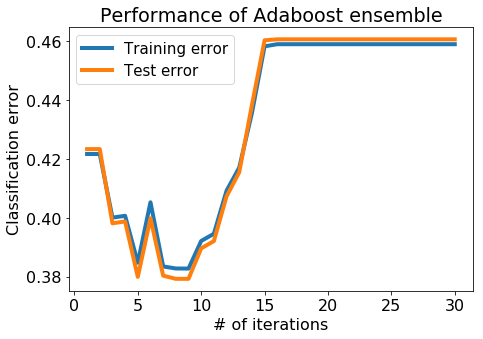

In [205]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()